In [6]:
import numpy as np
from planning_centerline_calculation.utils.math_utils import unit2dVectorFromAngle, rotate, angleFrom2dVector
from planning_centerline_calculation.utils.cone_types import ConeTypes
from planning_centerline_calculation.types import FloatArray

In [7]:
from planning_centerline_calculation.cones_sorting.core_cone_sorter import ConeSorter
from planning_centerline_calculation.cones_sorting.adjecency_matrix import AdjacencyMatrix
from planning_centerline_calculation.cones_sorting.end_configurations import findAllEndConfigurations
from planning_centerline_calculation.cones_sorting.cost_function import costConfigurations

In [8]:
phi_inner = np.arange(0, np.pi / 2, np.pi / 15)
phi_outer = np.arange(0, np.pi / 2, np.pi / 20)

points_inner = unit2dVectorFromAngle(phi_inner) * 9
points_outer = unit2dVectorFromAngle(phi_outer) * 12

center = np.mean((points_inner[:2] + points_outer[:2]) / 2, axis=0)
points_inner -= center
points_outer -= center

rotated_points_inner = rotate(points_inner, -np.pi / 2)
rotated_points_outer = rotate(points_outer, -np.pi / 2)
cones_left_raw = rotated_points_inner
cones_right_raw = rotated_points_outer


rng = np.random.default_rng(0)
rng.shuffle(cones_left_raw)
rng.shuffle(cones_right_raw)


car_position = np.array([0.0, 0.0])
car_direction = np.array([1.0, 0.0])

In [9]:
mask_is_left = np.ones(len(cones_left_raw), dtype=bool)
mask_is_right = np.ones(len(cones_right_raw), dtype=bool)

# for demonstration purposes, we will only keep the color of the first 4 cones
# on each side
mask_is_left[np.argsort(np.linalg.norm(cones_left_raw, axis=1))[4:]] = False
mask_is_right[np.argsort(np.linalg.norm(cones_right_raw, axis=1))[4:]] = False

cones_left = cones_left_raw[mask_is_left]
cones_right = cones_right_raw[mask_is_right]
cones_unknown = np.row_stack(
    [cones_left_raw[~mask_is_left], cones_right_raw[~mask_is_right]]
)

/home/mohd_yasser1/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


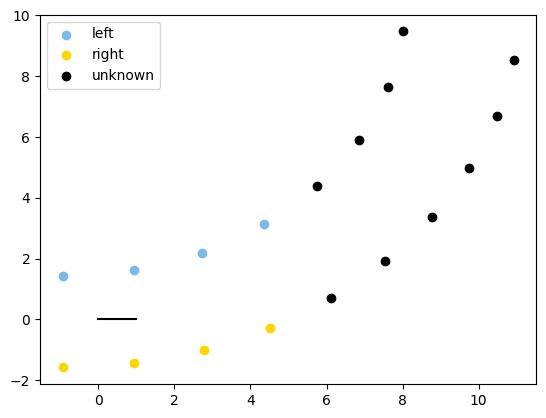

In [10]:
import matplotlib.pyplot as plt

blue_color = "#7CB9E8"
yellow_color = "gold"

plt.scatter(cones_left[:, 0], cones_left[:, 1], c=blue_color, label="left")
plt.scatter(cones_right[:, 0], cones_right[:, 1], c=yellow_color, label="right")
plt.scatter(cones_unknown[:, 0], cones_unknown[:, 1], c="k", label="unknown")
plt.legend()
plt.plot(
    [car_position[0], car_position[0] + car_direction[0]],
    [car_position[1], car_position[1] + car_direction[1]],
    c="k",
)

In [11]:
sorter = ConeSorter(3, 3, 5, 10, 0, 0.5)

In [12]:
for i, c in enumerate(ConeTypes):
    print(c, f"= {i}")

cones_by_type = [np.zeros((0, 2)) for _ in range(5)]
cones_by_type[ConeTypes.LEFT] = cones_left
cones_by_type[ConeTypes.RIGHT] = cones_right
cones_by_type[ConeTypes.UNKNOWN] = cones_unknown

ConeTypes.UNKNOWN = 0
ConeTypes.RIGHT = 1
ConeTypes.LEFT = 2
ConeTypes.START_FINISH_AREA = 3
ConeTypes.START_FINISH_LINE = 4


In [13]:
def flatten_cones_by_type_array(cones_by_type: list[FloatArray]) -> FloatArray:
    """Ravel the cones_by_type_array"""

    if (
        isinstance(cones_by_type, np.ndarray)
        and cones_by_type.ndim == 2
        and cones_by_type.shape[1] == 3
    ):
        return cones_by_type

    n_all_cones = sum(map(len, cones_by_type))

    # (x, y, color)
    out = np.empty((n_all_cones, 3))
    n_start = 0
    for cone_type in ConeTypes:
        n_cones = len(cones_by_type[cone_type])
        out[n_start : n_start + n_cones, :2] = cones_by_type[cone_type].reshape(-1, 2)
        out[n_start : n_start + n_cones, 2] = cone_type
        n_start += n_cones

    return out

In [14]:
cones_flat = flatten_cones_by_type_array(cones_by_type)
car_direction = angleFrom2dVector(car_direction)

In [15]:

first_k = sorter.selectFirstKStartingCones(car_position, car_direction, cones_flat, ConeTypes.LEFT)

first_r = sorter.selectFirstKStartingCones(car_position, car_direction, cones_flat, ConeTypes.RIGHT)

In [16]:
first_r

array([12, 13])

In [17]:
car_direction = unit2dVectorFromAngle(car_direction)

array([[-0.9371047 ,  1.41389712,  2.        ]])

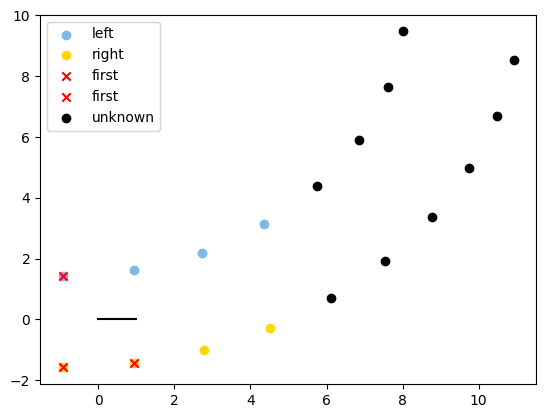

In [18]:
blue_color = "#7CB9E8"
yellow_color = "gold"

plt.scatter(cones_left[:, 0], cones_left[:, 1], c=blue_color, label="left")
plt.scatter(cones_right[:, 0], cones_right[:, 1], c=yellow_color, label="right")
plt.scatter(cones_flat[first_k, 0], cones_flat[first_k, 1], marker="x", c="r", label="first")
plt.scatter(cones_flat[first_r, 0], cones_flat[first_r, 1], marker="x", c="r", label="first")
plt.scatter(cones_unknown[:, 0], cones_unknown[:, 1], c="k", label="unknown")
plt.legend()
plt.plot(
    [car_position[0], car_position[0] + car_direction[0]],
    [car_position[1], car_position[1] + car_direction[1]],
    c="k",
)
cones_flat[first_k]

In [19]:
# phi_inner = np.arange(0, np.pi, np.pi / 15)
# phi_outer = np.arange(0, np.pi, np.pi / 20)

# points_inner = unit2dVectorFromAngle(phi_inner) * 9
# points_outer = unit2dVectorFromAngle(phi_outer) * 12

# center = np.mean((points_inner[:2] + points_outer[:2]) / 2, axis=0)
# points_inner -= center
# points_outer -= center

# rotated_points_inner = rotate(points_inner, -np.pi)
# rotated_points_outer = rotate(points_outer, -np.pi)
# cones_left_raw = rotated_points_inner
# cones_right_raw = rotated_points_outer


# rng = np.random.default_rng(0)
# rng.shuffle(cones_left_raw)
# rng.shuffle(cones_right_raw)


# car_position = np.array([10.0, -10.0])
# car_direction = np.array([1.0, 0.0])

# # mask_is_left = np.ones(len(cones_left_raw), dtype=bool)
# # mask_is_right = np.ones(len(cones_right_raw), dtype=bool)

# # for demonstration purposes, we will only keep the color of the first 4 cones
# # # on each side
# # mask_is_left[np.argsort(np.linalg.norm(cones_left_raw, axis=1))[6:]] = False
# # mask_is_right[np.argsort(np.linalg.norm(cones_right_raw, axis=1))[6:]] = False

# cones_left = cones_left_raw
# cones_right = cones_right_raw
# # cones_unknown = np.row_stack(
#     # [cones_left_raw[~mask_is_left], cones_right_raw[~mask_is_right]])


# blue_color = "#7CB9E8"
# yellow_color = "gold"

# plt.scatter(cones_left[:, 0], cones_left[:, 1], c=blue_color, label="left")
# plt.scatter(cones_right[:, 0], cones_right[:, 1], c=yellow_color, label="right")
# plt.scatter(cones_unknown[:, 0], cones_unknown[:, 1], c="k", label="unknown")
# plt.legend()
# plt.plot(
#     [car_position[0], car_position[0] + car_direction[0]],
#     [car_position[1], car_position[1] + car_direction[1]],
#     c="k",
# )

In [20]:
matrix = AdjacencyMatrix(6.5)
adjacencyMatrix, reachableNodes = matrix.createAdjacencyMatrix(cones_flat, 5, first_k, ConeTypes.LEFT)

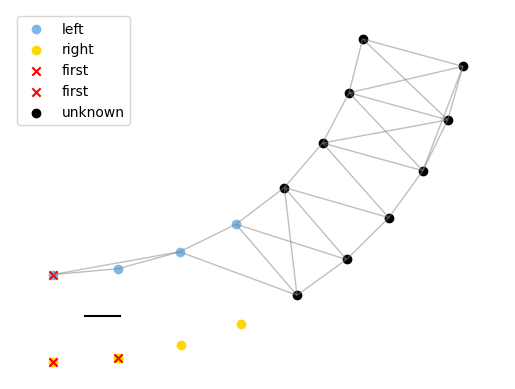

In [21]:
import networkx as nx

blue_color = "#7CB9E8"
yellow_color = "gold"

# Scatter plot of cones
plt.scatter(cones_left[:, 0], cones_left[:, 1], c=blue_color, label="left")
plt.scatter(cones_right[:, 0], cones_right[:, 1], c=yellow_color, label="right")
plt.scatter(cones_flat[first_k, 0], cones_flat[first_k, 1], marker="x", c="r", label="first")
plt.scatter(cones_flat[first_r, 0], cones_flat[first_r, 1], marker="x", c="r", label="first")
plt.scatter(cones_unknown[:, 0], cones_unknown[:, 1], c="k", label="unknown")

# Create a graph from the adjacency matrix
graph = nx.Graph(adjacencyMatrix)

# Draw the graph with the same layout as the scatter plot
pos = {i: (cones_flat[i, 0], cones_flat[i, 1]) for i in range(len(cones_flat))}
nx.draw(graph, pos, with_labels=False, node_size=0, edge_color='gray', alpha=0.5)

# Plot car direction
plt.plot(
    [car_position[0], car_position[0] + car_direction[0]],
    [car_position[1], car_position[1] + car_direction[1]],
    c="k",
)

plt.legend()
plt.show()

In [22]:
adjacencyMatrix, reachableNodes = matrix.createAdjacencyMatrix(cones_flat, 5, first_r[0], ConeTypes.RIGHT)

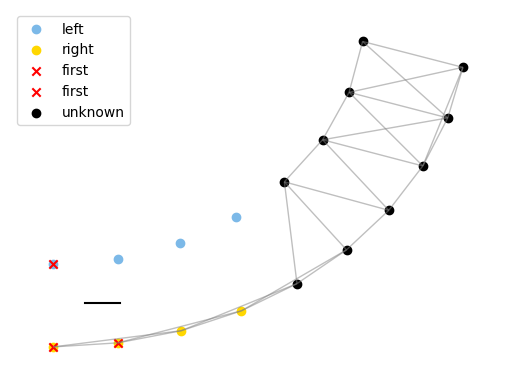

In [23]:
import networkx as nx

blue_color = "#7CB9E8"
yellow_color = "gold"

# Scatter plot of cones
plt.scatter(cones_left[:, 0], cones_left[:, 1], c=blue_color, label="left")
plt.scatter(cones_right[:, 0], cones_right[:, 1], c=yellow_color, label="right")
plt.scatter(cones_flat[first_k, 0], cones_flat[first_k, 1], marker="x", c="r", label="first")
plt.scatter(cones_flat[first_r, 0], cones_flat[first_r, 1], marker="x", c="r", label="first")
plt.scatter(cones_unknown[:, 0], cones_unknown[:, 1], c="k", label="unknown")

# Create a graph from the adjacency matrix
graph = nx.Graph(adjacencyMatrix)

# Draw the graph with the same layout as the scatter plot
pos = {i: (cones_flat[i, 0], cones_flat[i, 1]) for i in range(len(cones_flat))}
nx.draw(graph, pos, with_labels=False, node_size=0, edge_color='gray', alpha=0.5)

# Plot car direction
plt.plot(
    [car_position[0], car_position[0] + car_direction[0]],
    [car_position[1], car_position[1] + car_direction[1]],
    c="k",
)

plt.legend()
plt.show()

In [24]:
car_direction_angle = angleFrom2dVector(car_direction)

In [25]:
adjacencyMatrix, reachableNodes = matrix.createAdjacencyMatrix(cones_flat, 5, first_k, ConeTypes.LEFT)
allEndConfigurations, history = findAllEndConfigurations(
    cones_flat,
    ConeTypes.LEFT,
    first_k[0],
    adjacencyMatrix,
    8,
    40,
    70,
    first_k,
    car_position,
    car_direction_angle,
    carSize=2.5,
    storeAllEndConfigurations=True,
)



[16 17 14 15  8 -1 -1 -1]
42
[16 17 14  6  8  5  7 -1]
20


In [26]:
len(allEndConfigurations)

18

[16 17 14  6  8  5  7 -1]


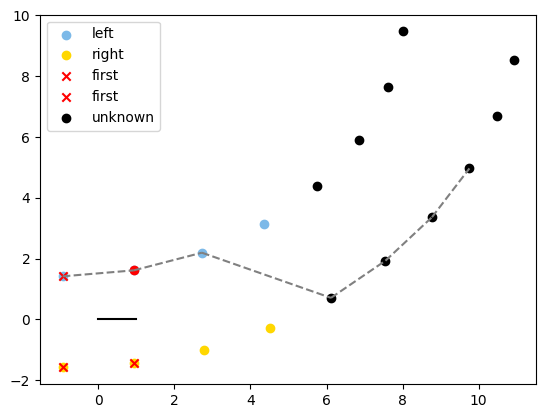

In [27]:
sequence = allEndConfigurations[0]
print(sequence)

# Scatter plot of cones
plt.scatter(cones_left[:, 0], cones_left[:, 1], c=blue_color, label="left")
plt.scatter(cones_right[:, 0], cones_right[:, 1], c=yellow_color, label="right")
plt.scatter(cones_flat[first_k, 0], cones_flat[first_k, 1], marker="x", c="r", label="first")
plt.scatter(cones_flat[first_r, 0], cones_flat[first_r, 1], marker="x", c="r", label="first")
plt.scatter(cones_unknown[:, 0], cones_unknown[:, 1], c="k", label="unknown")

# Plot the sequence of cones as a line
for i in range(len(sequence) - 1):
    cone_start = sequence[i]
    cone_end = sequence[i + 1]
    
    # Check if the next cone index is -1, if yes, break the loop
    if cone_end == -1:
        break
    
    plt.plot(
        [cones_flat[cone_start, 0], cones_flat[cone_end, 0]],
        [cones_flat[cone_start, 1], cones_flat[cone_end, 1]],
        c="gray", linestyle="--"
    )

plt.scatter(cones_flat[17,0], cones_flat[17,1], c="r")

# Plot car direction
plt.plot(
    [car_position[0], car_position[0] + car_direction[0]],
    [car_position[1], car_position[1] + car_direction[1]],
    c="k",
)

plt.legend()
plt.show()


In [28]:
import matplotlib.pyplot as plt
showAll = False
if showAll == True:
    # Calculate the number of rows required based on the number of configurations
    num_rows = len(allEndConfigurations)

    # Set the figure size to accommodate the subplots
    plt.figure(figsize=(10, 5 * num_rows))

    # Iterate over each configuration and create a subplot
    for idx, sequence in enumerate(allEndConfigurations):
        plt.subplot(num_rows, 1, idx + 1)
        
        # Scatter plot of cones
        plt.scatter(cones_left[:, 0], cones_left[:, 1], c=blue_color, label="left")
        plt.scatter(cones_right[:, 0], cones_right[:, 1], c=yellow_color, label="right")
        plt.scatter(cones_flat[first_k, 0], cones_flat[first_k, 1], marker="x", c="r", label="first")
        plt.scatter(cones_flat[first_r, 0], cones_flat[first_r, 1], marker="x", c="r", label="first")
        plt.scatter(cones_unknown[:, 0], cones_unknown[:, 1], c="k", label="unknown")

        # Plot the sequence of cones as a line
        for i in range(len(sequence) - 1):
            cone_start = sequence[i]
            cone_end = sequence[i + 1]

            # Check if the next cone index is -1, if yes, break the loop
            if cone_end == -1:
                break

            plt.plot(
                [cones_flat[cone_start, 0], cones_flat[cone_end, 0]],
                [cones_flat[cone_start, 1], cones_flat[cone_end, 1]],
                c="gray", linestyle="--"
            )

        plt.scatter(cones_flat[17,0], cones_flat[17,1], c="r")

        # Plot car direction
        plt.plot(
            [car_position[0], car_position[0] + car_direction[0]],
            [car_position[1], car_position[1] + car_direction[1]],
            c="k",
        )

        plt.legend()

    plt.tight_layout()
    plt.show()


In [29]:
car_direction_angle = angleFrom2dVector(car_direction)

In [30]:
costs = costConfigurations(
    cones_flat,
    allEndConfigurations,
    ConeTypes.LEFT,
    car_position,
    car_direction_angle,
    returnIndividualCosts=True,
)

idx_sort_cost = costs.sum(axis=1).argsort()
best_config = allEndConfigurations[idx_sort_cost[0]]
print(costs[idx_sort_cost[0]])
print(costs[idx_sort_cost[5]])

[13 22 19 19 13 28 25 27 23 21 20 21 18 18 16 23 19 17]
[19  1 11  5 12  0  6  5  4 10  6  2  9  8 13  2  9 14]
[0.00724638 0.         0.07763975 0.01138258 0.         0.00310559
 0.        ]
[0.05859001 0.00830973 0.07763975 0.01138258 0.         0.0041806
 0.11544635]


[16 17 14 15  0  2  1 -1]


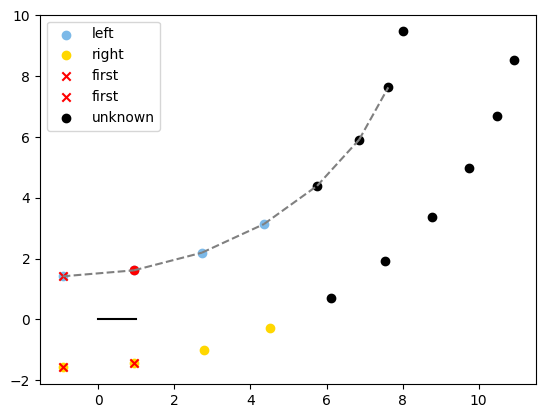

In [31]:
sequence = best_config
print(sequence)

# Scatter plot of cones
plt.scatter(cones_left[:, 0], cones_left[:, 1], c=blue_color, label="left")
plt.scatter(cones_right[:, 0], cones_right[:, 1], c=yellow_color, label="right")
plt.scatter(cones_flat[first_k, 0], cones_flat[first_k, 1], marker="x", c="r", label="first")
plt.scatter(cones_flat[first_r, 0], cones_flat[first_r, 1], marker="x", c="r", label="first")
plt.scatter(cones_unknown[:, 0], cones_unknown[:, 1], c="k", label="unknown")

# Plot the sequence of cones as a line
for i in range(len(sequence) - 1):
    cone_start = sequence[i]
    cone_end = sequence[i + 1]
    
    # Check if the next cone index is -1, if yes, break the loop
    if cone_end == -1:
        break
    
    plt.plot(
        [cones_flat[cone_start, 0], cones_flat[cone_end, 0]],
        [cones_flat[cone_start, 1], cones_flat[cone_end, 1]],
        c="gray", linestyle="--"
    )

plt.scatter(cones_flat[17,0], cones_flat[17,1], c="r")

# Plot car direction
plt.plot(
    [car_position[0], car_position[0] + car_direction[0]],
    [car_position[1], car_position[1] + car_direction[1]],
    c="k",
)

plt.legend()
plt.show()


Right Configs


In [32]:
matrix = AdjacencyMatrix(6.5)
adjacencyMatrix_r, reachableNodes = matrix.createAdjacencyMatrix(cones_flat, 5, first_r[0], ConeTypes.RIGHT)
allEndConfigurations_r, history = findAllEndConfigurations(
    cones_flat,
    ConeTypes.RIGHT,
    first_r[0],
    adjacencyMatrix_r,
    8,
    40,
    70,
    first_r,
    car_position,
    car_direction_angle,
    carSize=2.5,
    storeAllEndConfigurations=True,
)



[12 13 10 11  6  8  5 -1]
1
[12 13 10 11  6  8  5 -1]
1


In [33]:
len(allEndConfigurations_r)

1

In [34]:
costs_r = costConfigurations(
    cones_flat,
    allEndConfigurations_r,
    ConeTypes.RIGHT,
    car_position,
    car_direction_angle,
    returnIndividualCosts=True,
)

idx_sort_cost_r = costs_r.sum(axis=1).argsort()
best_config_r = allEndConfigurations_r[idx_sort_cost_r[0]]

[30]
[0]


[12 13 10 11  6  8  5 -1]


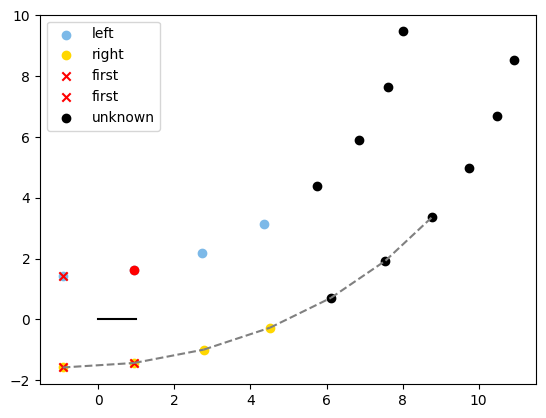

In [35]:
sequence = best_config_r
print(sequence)

# Scatter plot of cones
plt.scatter(cones_left[:, 0], cones_left[:, 1], c=blue_color, label="left")
plt.scatter(cones_right[:, 0], cones_right[:, 1], c=yellow_color, label="right")
plt.scatter(cones_flat[first_k, 0], cones_flat[first_k, 1], marker="x", c="r", label="first")
plt.scatter(cones_flat[first_r, 0], cones_flat[first_r, 1], marker="x", c="r", label="first")
plt.scatter(cones_unknown[:, 0], cones_unknown[:, 1], c="k", label="unknown")

# Plot the sequence of cones as a line
for i in range(len(sequence) - 1):
    cone_start = sequence[i]
    cone_end = sequence[i + 1]
    
    # Check if the next cone index is -1, if yes, break the loop
    if cone_end == -1:
        break
    
    plt.plot(
        [cones_flat[cone_start, 0], cones_flat[cone_end, 0]],
        [cones_flat[cone_start, 1], cones_flat[cone_end, 1]],
        c="gray", linestyle="--"
    )

plt.scatter(cones_flat[17,0], cones_flat[17,1], c="r")

# Plot car direction
plt.plot(
    [car_position[0], car_position[0] + car_direction[0]],
    [car_position[1], car_position[1] + car_direction[1]],
    c="k",
)

plt.legend()
plt.show()


### Full Cone Sorting Module

In [36]:
from planning_centerline_calculation.cones_sorting.cone_sorting_wrapper import ConeSortingInput, ConeSorting

In [37]:
coneSorting = ConeSorting(
        maxNNeighbors=5,
        maxDist=6.5,
        maxDistToFirst=6.0,
        maxLength=12, #default=12
        thresholdDirectionalAngle=np.deg2rad(40),
        thresholdAbsoluteAngle=np.deg2rad(65),
        useUnknownCones=True,
)
coneSortingInput = ConeSortingInput(
        cones_by_type,
        car_position,
        car_direction_angle
)
coneSorting.setNewInput(coneSortingInput)

sortedLeft, sortedRight = coneSorting.runConeSorting()

[16 17 14 15 -1 -1 -1 -1 -1 -1 -1 -1]
6
[16 17 14  6  8  5  7  9 -1 -1 -1 -1]
5
[13 28 27]
[23  0  5]
[12 13 10 11  6  8  5  7  9 -1 -1 -1]
1
[12 13 10 11  6  8  5  7  9 -1 -1 -1]
1
[39]
[0]


In [38]:
sortedLeft

array([[-0.9371047 ,  1.41389712],
       [ 0.93410052,  1.61056872],
       [ 2.72352509,  2.191988  ],
       [ 4.35296257,  3.13274417],
       [ 5.75119873,  4.39172167],
       [ 6.85712393,  5.91389712],
       [ 7.62240395,  7.63274417]])

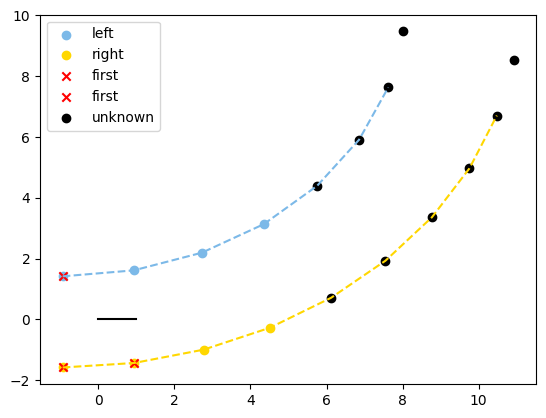

In [39]:
# Scatter plot of cones
plt.scatter(cones_left[:, 0], cones_left[:, 1], c=blue_color, label="left")
plt.scatter(cones_right[:, 0], cones_right[:, 1], c=yellow_color, label="right")
plt.scatter(cones_flat[first_k, 0], cones_flat[first_k, 1], marker="x", c="r", label="first")
plt.scatter(cones_flat[first_r, 0], cones_flat[first_r, 1], marker="x", c="r", label="first")
plt.scatter(cones_unknown[:, 0], cones_unknown[:, 1], c="k", label="unknown")

# Plot the sequence of cones as connected lines for left cones
plt.plot(sortedLeft[:, 0], sortedLeft[:, 1], c=blue_color, linestyle="--")

# Plot the sequence of cones as connected lines for right cones
plt.plot(sortedRight[:, 0], sortedRight[:, 1], c=yellow_color, linestyle="--")

# Plot car direction
plt.plot(
    [car_position[0], car_position[0] + car_direction[0]],
    [car_position[1], car_position[1] + car_direction[1]],
    c="k",
)

plt.legend()
plt.show()
